In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gcsfs

Note: you may need to restart the kernel to use updated packages.


In [3]:
!nvidia-smi

Fri Aug 18 06:21:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |      0MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from transformers import get_linear_schedule_with_warmup, BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import torch.optim as optim
import torch.nn as nn
import os
import numpy as np
import time
import pandas as pd
import numpy as np

In [3]:
import torch
torch.cuda.empty_cache()

In [6]:
import pandas as pd

# Define the path to the CSV file in GCS
csv_path = "gs://vino-verdict/data/wine_88.csv"

# Read the CSV using pandas
df = pd.read_csv(csv_path)

In [7]:
df.head()

,country,description,points,price,province,region_1,title,variety,winery,year,verdict
0,US,This light-tasting wine is a soft and easy sip...,88,30.0,California,Anderson Valley,Clif Family 2015 Gewürztraminer (Anderson Valley),Gewürztraminer,Clif Family,2015,bad
1,Italy,"This opens with aromas of black cherry, chocol...",87,10.0,Sicily & Sardinia,Sicilia,Feudo Arancio 2011 Cabernet Sauvignon (Sicilia),Cabernet Sauvignon,Feudo Arancio,2011,bad
2,Portugal,"Perfumed and exotic, the wine has a touch of l...",86,13.0,Douro,NaN,Quinta de Porrais 2012 Parcelas White (Douro),Portuguese White,Quinta de Porrais,2012,bad
3,US,Although brambly and green with hints of tomat...,83,16.0,New York,Finger Lakes,Hunt Country Vineyards 2008 Cabernet Franc (Fi...,Cabernet Franc,Hunt Country Vineyards,2008,bad
4,US,"A nice Chardonnay to drink now, with rich trop...",87,25.0,California,Napa Valley,Silverado 2009 Estate Grown Chardonnay (Napa V...,Chardonnay,Silverado,2009,bad


In [8]:
# 1. Preprocess the `description` column

# Check for missing values in the description and verdict columns
missing_values = df[['description', 'verdict']].isnull().sum()

# Drop rows with missing descriptions (if any)
df = df.dropna(subset=['description'])

# Display missing values and the head of the DataFrame
missing_values, df[['description', 'verdict']].head()

(description    0
 verdict        0
 dtype: int64,
                                          description verdict
 0  This light-tasting wine is a soft and easy sip...     bad
 1  This opens with aromas of black cherry, chocol...     bad
 2  Perfumed and exotic, the wine has a touch of l...     bad
 3  Although brambly and green with hints of tomat...     bad
 4  A nice Chardonnay to drink now, with rich trop...     bad)

In [9]:
df['verdict'].value_counts()

verdict
bad     54831
good    54831
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

# Splitting the dataframe
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['verdict'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['verdict'], random_state=42)

In [11]:
train_df.shape, valid_df.shape, test_df.shape

((87729, 11), (10966, 11), (10967, 11))

In [12]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Tokenize the descriptions from the train, validation, and test sets
train_encodings = tokenizer(list(train_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(valid_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_df['description']), truncation=True, padding=True, max_length=128, return_tensors='pt')

train_encodings.keys()  # Display the keys to check the tokenization results

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
# Convert 'bad' and 'good' to 0 and 1, respectively
train_labels = torch.tensor((train_df['verdict'] == 'good').to_numpy()).long()
val_labels = torch.tensor((valid_df['verdict'] == 'good').to_numpy()).long()
test_labels = torch.tensor((test_df['verdict'] == 'good').to_numpy()).long()

train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

In [1]:
!nvidia-smi

Sat Aug 19 08:03:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.56                 Driver Version: 532.09       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060         On | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8                3W /  N/A|      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Training hyperparameters and initialization
batch_size = 32
epochs = 5
patience = 2

# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

# Early stopping and model saving initializations
best_val_loss = float('inf')
no_improve_epochs = 0
path_to_save = "gs://vino-verdict/models/multilingual-binary-sentiment_88.bin"

In [17]:
# Load the BERT model for binary classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-uncased', 
    num_labels=2  # For binary classification
)
model = model.to(device)

# Loss function for binary cross entropy
# Use BCEWithLogitsLoss for binary classification with logits (includes sigmoid activation)
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
# Look into perhaps using a Learning Rate Decay
# This starts with a higher learning rate and slowly reduces it

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

# DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Early stopping variables
best_val_f1 = -float('inf')
no_improve_epochs = 0
patience = 3
epochs = 5
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
train_accuracies = []
gradient_accumulation_steps = 2

# 1. Setup the checkpoint directory
notebook_name = "multilingual-binary-sentiment_88"
checkpoint_dir = f'./checkpoints_{notebook_name}/'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Check if there's an existing checkpoint and load it
latest_checkpoint = None
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')])
if checkpoints:
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
    print(f"Loading from checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch = 0

print("Starting training...\n")

# Adjust the loop to start from the right epoch
for epoch in range(start_epoch, epochs):
    model.train()
    total_train_loss = 0
    train_predictions, train_true_vals = [], []

    optimizer.zero_grad()  # Reset gradients once at the start of the epoch

    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        
        loss = loss_function(outputs.logits, labels)  # Adjusted loss calculation
        total_train_loss += loss.item()

        # Gradient accumulation
        loss = loss / gradient_accumulation_steps  # Normalize the loss
        loss.backward()

        # Get binary predictions for training data
        batch_train_predictions = torch.argmax(outputs.logits, dim=1)  # Adjusted prediction calculation
        train_predictions.extend(batch_train_predictions.cpu().numpy())
        train_true_vals.extend(labels.cpu().numpy())
        
        # Update model parameters every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
            optimizer.step()
            optimizer.zero_grad()
            
        # Print every 100 batches to see progress
        if step % 100 == 0:
            print(f"Epoch {epoch+1} - Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)  # Calculate average training loss
    
    # 2. Save a checkpoint at the end of each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch:03}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_train_loss
    }, checkpoint_path)

    # If you're using Google Cloud Storage, copy this checkpoint to your bucket:
    os.system(f"gsutil cp {checkpoint_path} gs://vino-verdict/checkpoints")

    train_losses.append(avg_train_loss)
    
    train_accuracy = accuracy_score(train_true_vals, train_predictions)
    train_accuracies.append(train_accuracy)

    scheduler.step()

    # Validation at the end of each epoch
    model.eval()
    val_loss = 0
    predictions, true_vals = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask)
            
            val_loss += loss_function(outputs.logits, labels).item()
            
            # Get binary predictions
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            predictions.extend(batch_predictions.cpu().numpy())
            true_vals.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(true_vals, predictions)
    val_f1 = f1_score(true_vals, predictions)
    
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    print(f"\nEpoch {epoch+1}/{epochs} Summary:")
    print(f"Training Loss: {avg_train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation F1: {val_f1:.4f}\n")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs == patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break
    
    # Save the model if it's the best one seen so far
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        print("Saving the best model...\n")

        # Save model weights
        torch.save(model.state_dict(), "./multilingual-binary-sentiment_88.bin")
        os.system(f"gsutil cp ./multilingual-binary-sentiment_88.bin {path_to_save}")

        # Save the model's configuration
        config_path = "./multilingual-binary-sentiment_88.json"
        model.config.to_json_file(config_path)
        os.system(f"gsutil cp {config_path} gs://vino-verdict/models/")

print("Training completed.")

Starting training...

Epoch 1 - Step 0/2742 - Loss: 0.3490
Epoch 1 - Step 100/2742 - Loss: 0.2259
Epoch 1 - Step 200/2742 - Loss: 0.1944
Epoch 1 - Step 300/2742 - Loss: 0.1548
Epoch 1 - Step 400/2742 - Loss: 0.1958
Epoch 1 - Step 500/2742 - Loss: 0.2143
Epoch 1 - Step 600/2742 - Loss: 0.1840
Epoch 1 - Step 700/2742 - Loss: 0.1867
Epoch 1 - Step 800/2742 - Loss: 0.1921
Epoch 1 - Step 900/2742 - Loss: 0.2744
Epoch 1 - Step 1000/2742 - Loss: 0.1839
Epoch 1 - Step 1100/2742 - Loss: 0.1687
Epoch 1 - Step 1200/2742 - Loss: 0.1894
Epoch 1 - Step 1300/2742 - Loss: 0.1799
Epoch 1 - Step 1400/2742 - Loss: 0.1552
Epoch 1 - Step 1500/2742 - Loss: 0.2019
Epoch 1 - Step 1600/2742 - Loss: 0.1505
Epoch 1 - Step 1700/2742 - Loss: 0.1885
Epoch 1 - Step 1800/2742 - Loss: 0.1585
Epoch 1 - Step 1900/2742 - Loss: 0.2463
Epoch 1 - Step 2000/2742 - Loss: 0.2464
Epoch 1 - Step 2100/2742 - Loss: 0.2229
Epoch 1 - Step 2200/2742 - Loss: 0.1726
Epoch 1 - Step 2300/2742 - Loss: 0.2182
Epoch 1 - Step 2400/2742 - Los

Copying file://./checkpoints_multilingual-binary-sentiment_88/checkpoint_epoch_000.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][  1.9 GiB/  1.9 GiB]   31.9 MiB/s                                   
Operation completed over 1 objects/1.9 GiB.                                      



Epoch 1/5 Summary:
Training Loss: 0.4002 - Training Accuracy: 0.8141
Validation Loss: 0.3608 - Validation Accuracy: 0.8405 - Validation F1: 0.8355

Saving the best model...



Copying file://./multilingual-binary-sentiment_88.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][638.5 MiB/638.5 MiB]   32.3 MiB/s                                   
Operation completed over 1 objects/638.5 MiB.                                    
Copying file://./multilingual-binary-sentiment_88.json

Epoch 2 - Step 0/2742 - Loss: 0.1058
Epoch 2 - Step 100/2742 - Loss: 0.1089
Epoch 2 - Step 200/2742 - Loss: 0.2185
Epoch 2 - Step 300/2742 - Loss: 0.1696
Epoch 2 - Step 400/2742 - Loss: 0.1731
Epoch 2 - Step 500/2742 - Loss: 0.2130
Epoch 2 - Step 600/2742 - Loss: 0.1699
Epoch 2 - Step 700/2742 - Loss: 0.2393
Epoch 2 - Step 800/2742 - Loss: 0.1830
Epoch 2 - Step 900/2742 - Loss: 0.2586
Epoch 2 - Step 1000/2742 - Loss: 0.2505
Epoch 2 - Step 1100/2742 - Loss: 0.1223
Epoch 2 - Step 1200/2742 - Loss: 0.1825
Epoch 2 - Step 1300/2742 - Loss: 0.1280
Epoch 2 - Step 1400/2742 - Loss: 0.1775
Epoch 2 - Step 1500/2742 - Loss: 0.1705
Epoch 2 - Step 1600/2742 - Loss: 0.2304
Epoch 2 - Step 1700/2742 - Loss: 0.1455
Epoch 2 - Step 1800/2742 - Loss: 0.1226
Epoch 2 - Step 1900/2742 - Loss: 0.1864
Epoch 2 - Step 2000/2742 - Loss: 0.1308
Epoch 2 - Step 2100/2742 - Loss: 0.1881
Epoch 2 - Step 2200/2742 - Loss: 0.1772
Epoch 2 - Step 2300/2742 - Loss: 0.1860
Epoch 2 - Step 2400/2742 - Loss: 0.0768
Epoch 2 - St

Copying file://./checkpoints_multilingual-binary-sentiment_88/checkpoint_epoch_001.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][  1.9 GiB/  1.9 GiB]   31.8 MiB/s                                   
Operation completed over 1 objects/1.9 GiB.                                      



Epoch 2/5 Summary:
Training Loss: 0.3172 - Training Accuracy: 0.8583
Validation Loss: 0.3462 - Validation Accuracy: 0.8483 - Validation F1: 0.8493

Saving the best model...



Copying file://./multilingual-binary-sentiment_88.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][638.5 MiB/638.5 MiB]   32.3 MiB/s                                   
Operation completed over 1 objects/638.5 MiB.                                    
Copying file://./multilingual-binary-sentiment_88.json

Epoch 3 - Step 0/2742 - Loss: 0.1015
Epoch 3 - Step 100/2742 - Loss: 0.0493
Epoch 3 - Step 200/2742 - Loss: 0.1794
Epoch 3 - Step 300/2742 - Loss: 0.2023
Epoch 3 - Step 400/2742 - Loss: 0.1735
Epoch 3 - Step 500/2742 - Loss: 0.2115
Epoch 3 - Step 600/2742 - Loss: 0.1235
Epoch 3 - Step 700/2742 - Loss: 0.0820
Epoch 3 - Step 800/2742 - Loss: 0.2213
Epoch 3 - Step 900/2742 - Loss: 0.0404
Epoch 3 - Step 1000/2742 - Loss: 0.1156
Epoch 3 - Step 1100/2742 - Loss: 0.1410
Epoch 3 - Step 1200/2742 - Loss: 0.1019
Epoch 3 - Step 1300/2742 - Loss: 0.1205
Epoch 3 - Step 1400/2742 - Loss: 0.1182
Epoch 3 - Step 1500/2742 - Loss: 0.0548
Epoch 3 - Step 1600/2742 - Loss: 0.0532
Epoch 3 - Step 1700/2742 - Loss: 0.1219
Epoch 3 - Step 1800/2742 - Loss: 0.0838
Epoch 3 - Step 1900/2742 - Loss: 0.2833
Epoch 3 - Step 2000/2742 - Loss: 0.1058
Epoch 3 - Step 2100/2742 - Loss: 0.1209
Epoch 3 - Step 2200/2742 - Loss: 0.1458
Epoch 3 - Step 2300/2742 - Loss: 0.1064
Epoch 3 - Step 2400/2742 - Loss: 0.0944
Epoch 3 - St

Copying file://./checkpoints_multilingual-binary-sentiment_88/checkpoint_epoch_002.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][  1.9 GiB/  1.9 GiB]   32.0 MiB/s                                   
Operation completed over 1 objects/1.9 GiB.                                      



Epoch 3/5 Summary:
Training Loss: 0.2743 - Training Accuracy: 0.8781
Validation Loss: 0.3625 - Validation Accuracy: 0.8476 - Validation F1: 0.8509

Saving the best model...



Copying file://./multilingual-binary-sentiment_88.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][638.5 MiB/638.5 MiB]   32.9 MiB/s                                   
Operation completed over 1 objects/638.5 MiB.                                    
Copying file://./multilingual-binary-sentiment_88.json

Epoch 4 - Step 0/2742 - Loss: 0.0836
Epoch 4 - Step 100/2742 - Loss: 0.1252
Epoch 4 - Step 200/2742 - Loss: 0.0718
Epoch 4 - Step 300/2742 - Loss: 0.1282
Epoch 4 - Step 400/2742 - Loss: 0.0666
Epoch 4 - Step 500/2742 - Loss: 0.1132
Epoch 4 - Step 600/2742 - Loss: 0.0835
Epoch 4 - Step 700/2742 - Loss: 0.0783
Epoch 4 - Step 800/2742 - Loss: 0.1344
Epoch 4 - Step 900/2742 - Loss: 0.0716
Epoch 4 - Step 1000/2742 - Loss: 0.1503
Epoch 4 - Step 1100/2742 - Loss: 0.0561
Epoch 4 - Step 1200/2742 - Loss: 0.1156
Epoch 4 - Step 1300/2742 - Loss: 0.0859
Epoch 4 - Step 1400/2742 - Loss: 0.1818
Epoch 4 - Step 1500/2742 - Loss: 0.1393
Epoch 4 - Step 1600/2742 - Loss: 0.1625
Epoch 4 - Step 1700/2742 - Loss: 0.1543
Epoch 4 - Step 1800/2742 - Loss: 0.1602
Epoch 4 - Step 1900/2742 - Loss: 0.1013
Epoch 4 - Step 2000/2742 - Loss: 0.0740
Epoch 4 - Step 2100/2742 - Loss: 0.1999
Epoch 4 - Step 2200/2742 - Loss: 0.1017
Epoch 4 - Step 2300/2742 - Loss: 0.1086
Epoch 4 - Step 2400/2742 - Loss: 0.1140
Epoch 4 - St

Copying file://./checkpoints_multilingual-binary-sentiment_88/checkpoint_epoch_003.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][  1.9 GiB/  1.9 GiB]   32.5 MiB/s                                   
Operation completed over 1 objects/1.9 GiB.                                      



Epoch 4/5 Summary:
Training Loss: 0.2441 - Training Accuracy: 0.8936
Validation Loss: 0.3801 - Validation Accuracy: 0.8429 - Validation F1: 0.8450

Epoch 5 - Step 0/2742 - Loss: 0.0829
Epoch 5 - Step 100/2742 - Loss: 0.1553
Epoch 5 - Step 200/2742 - Loss: 0.0980
Epoch 5 - Step 300/2742 - Loss: 0.0867
Epoch 5 - Step 400/2742 - Loss: 0.1198
Epoch 5 - Step 500/2742 - Loss: 0.1264
Epoch 5 - Step 600/2742 - Loss: 0.1072
Epoch 5 - Step 700/2742 - Loss: 0.2194
Epoch 5 - Step 800/2742 - Loss: 0.0866
Epoch 5 - Step 900/2742 - Loss: 0.0749
Epoch 5 - Step 1000/2742 - Loss: 0.0874
Epoch 5 - Step 1100/2742 - Loss: 0.0986
Epoch 5 - Step 1200/2742 - Loss: 0.1486
Epoch 5 - Step 1300/2742 - Loss: 0.1520
Epoch 5 - Step 1400/2742 - Loss: 0.1019
Epoch 5 - Step 1500/2742 - Loss: 0.0949
Epoch 5 - Step 1600/2742 - Loss: 0.1118
Epoch 5 - Step 1700/2742 - Loss: 0.0802
Epoch 5 - Step 1800/2742 - Loss: 0.0950
Epoch 5 - Step 1900/2742 - Loss: 0.0709
Epoch 5 - Step 2000/2742 - Loss: 0.0975
Epoch 5 - Step 2100/274

Copying file://./checkpoints_multilingual-binary-sentiment_88/checkpoint_epoch_004.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][  1.9 GiB/  1.9 GiB]   32.8 MiB/s                                   
Operation completed over 1 objects/1.9 GiB.                                      



Epoch 5/5 Summary:
Training Loss: 0.2268 - Training Accuracy: 0.9024
Validation Loss: 0.3956 - Validation Accuracy: 0.8433 - Validation F1: 0.8449

Early stopping triggered after 5 epochs!
Training completed.


In [19]:
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()
test_predictions, test_true_vals = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # Get class predictions
        batch_predictions = torch.argmax(outputs.logits, dim=1)
        test_predictions.extend(batch_predictions.cpu().numpy())
        test_true_vals.extend(labels.cpu().numpy())

In [21]:
unique_preds = set(test_predictions)
print("Unique predictions:", unique_preds)

Unique predictions: {0, 1}


In [22]:
from collections import Counter
class_distribution = Counter(test_true_vals)
print("Class distribution in test data:", class_distribution)

Class distribution in test data: Counter({0: 5484, 1: 5483})


In [23]:
# Compute evaluation metrics (e.g., accuracy, F1 score) using test_predictions and test_true_vals
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

# Calculate metrics
accuracy = accuracy_score(test_true_vals, test_predictions)
f1 = f1_score(test_true_vals, test_predictions)
conf_matrix = confusion_matrix(test_true_vals, test_predictions)
class_report = classification_report(test_true_vals, test_predictions, target_names=['bad', 'good'])
precision = precision_score(test_true_vals, test_predictions)
recall = recall_score(test_true_vals, test_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:\n", class_report)

Precision: 0.8411265571402781
Recall: 0.8497173080430421
Accuracy: 0.8446247834412328
F1 Score: 0.8454001088731627

Confusion Matrix:
[[4604  880]
 [ 824 4659]]

Classification Report:
               precision    recall  f1-score   support

         bad       0.85      0.84      0.84      5484
        good       0.84      0.85      0.85      5483

    accuracy                           0.84     10967
   macro avg       0.84      0.84      0.84     10967
weighted avg       0.84      0.84      0.84     10967



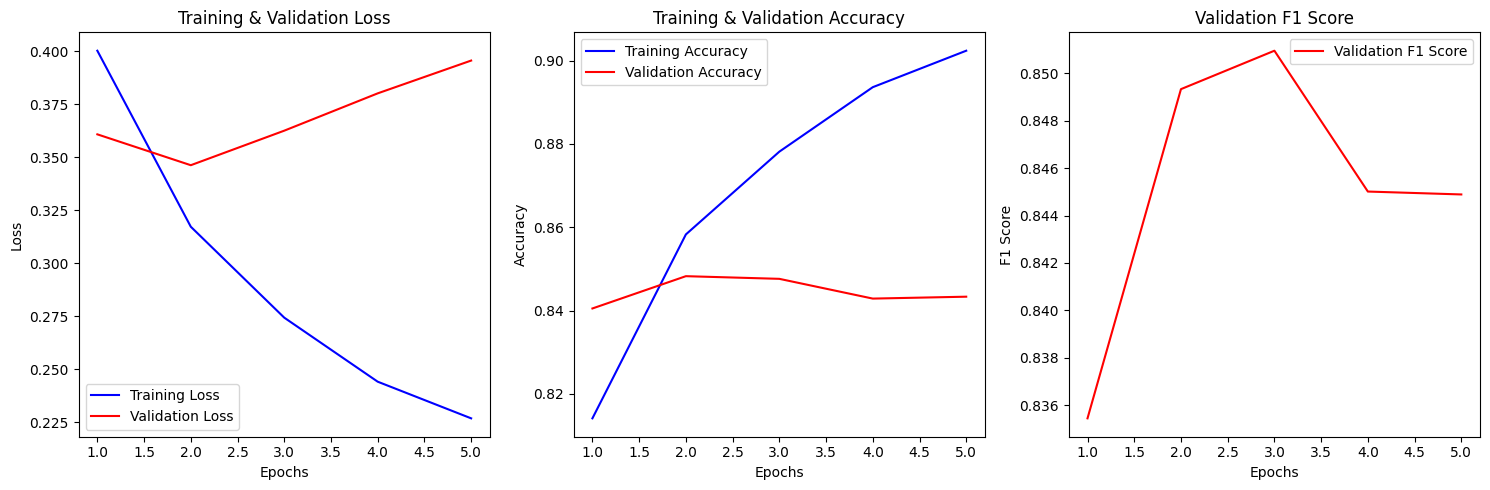

In [24]:
import matplotlib.pyplot as plt

# Your data
epochs_range = list(range(1, len(train_losses) + 1))
training_losses = train_losses
validation_accuracies = val_accuracies
validation_f1_scores = val_f1_scores
validation_losses = val_losses

# Plotting
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Training and Validation F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score', color='red')
# You can also add Training F1 Scores if you've computed them
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()